In [3522]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import sklearn

In [3523]:
img = cv2.imread('test_images/test8.jpeg')

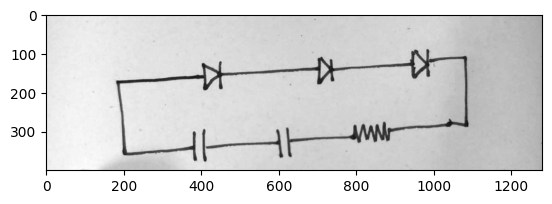

In [3524]:
# converting to grey scale

grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(grey_img, cmap='gray')


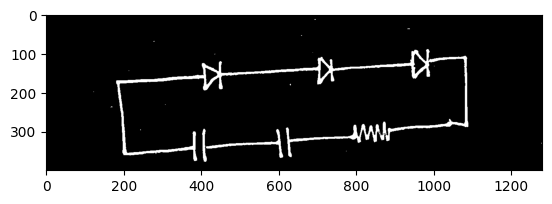

In [3525]:
# applying threshold

th = cv2.adaptiveThreshold(grey_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 31, 21)
plt.imshow(th, cmap='gray')

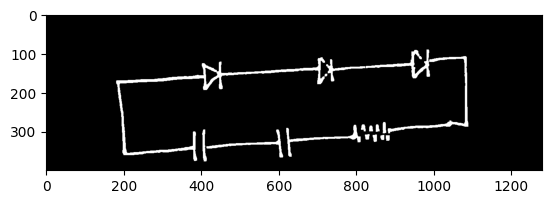

In [3526]:
# opening & removing noise grain in background
# i.e. eroding the img and then dialating it

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening_img = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=2)
plt.imshow(opening_img, cmap='gray')

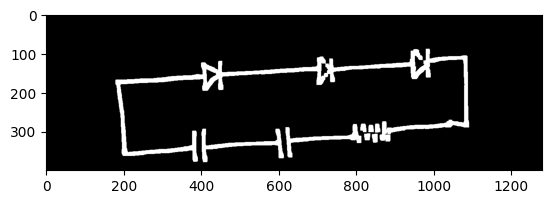

In [3527]:
# dialating again to make line thicker

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dline = cv2.dilate(opening_img, kernel, iterations=2)
plt.imshow(dline, cmap='gray')

In [3528]:
# # Detect corners using the contours
# corners = cv2.goodFeaturesToTrack(image=dline,maxCorners=50,qualityLevel=0.40,minDistance=50)
 
# # Draw the corners on the original image
# for corner in corners:
#     x,y = corner.ravel()
#     cv2.circle(img,(int(x),int(y)),5,(255,0,0),10)

# plt.imshow(img)

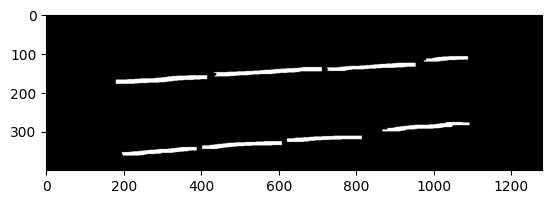

In [3529]:
# finding horizontal edges
h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
h_edges = cv2.morphologyEx(dline, cv2.MORPH_OPEN, h_kernel, iterations=1)
plt.imshow(h_edges, cmap='gray')

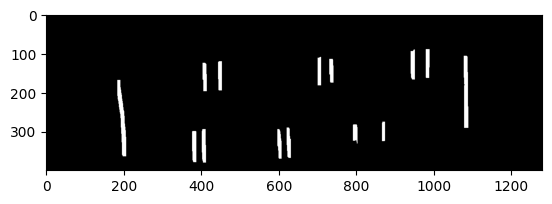

In [3530]:
# finding vertical edges
v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
v_edges = cv2.morphologyEx(dline, cv2.MORPH_OPEN, v_kernel, iterations=1)
plt.imshow(v_edges, cmap='gray')

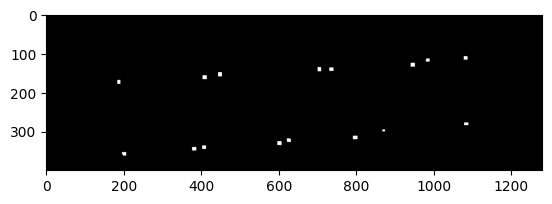

In [3531]:
intersect1 = cv2.bitwise_and(h_edges, v_edges)
plt.imshow(intersect1, cmap='gray')

In [3532]:
fast = cv2.FastFeatureDetector_create(threshold=10, nonmaxSuppression=False, type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
# fast = cv2.FastFeatureDetector_create()
kp = fast.detect(dline,None)

In [3533]:
keypoints = np.array([k.pt for k in kp], dtype=np.float32)
clustering = DBSCAN(eps=40, min_samples=30).fit(keypoints)
img7 = img.copy()
img8 = img.copy()

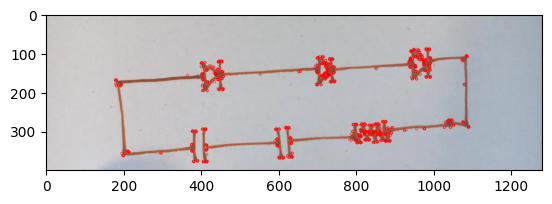

In [3534]:
img8 = cv2.drawKeypoints(img8, kp, None, color=(255,0,0))
plt.imshow(img8)

In [3535]:
labels = clustering.labels_
unique_labels, counts = np.unique(labels, return_counts=True)

In [3536]:
# Calculate cluster spreads
cluster_spreads = []
for label in unique_labels:
    if label == -1:
        continue
    cluster_points = keypoints[labels == label]
    if len(cluster_points) < 3:  # Minimum number of points to calculate spread
        continue
    centroid = np.mean(cluster_points, axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    spread = np.max(distances)
    cluster_spreads.append((label, spread))

# Remove clusters that are not spreaded enough
spread_threshold = 60  # Adjust the threshold as needed
filtered_labels = np.copy(labels)
for label, spread in cluster_spreads:
    if spread < spread_threshold:
        filtered_labels[filtered_labels == label] = -1

In [3537]:
print(cluster_spreads)

[(0, 49.64153), (1, 43.183), (2, 64.30682), (3, 88.68054), (4, 35.270992), (5, 42.934082), (6, 34.54814)]


In [3538]:
# Draw clusters on the image
for label in filtered_labels:
    if label == -1:
        continue
    else:
        color = np.random.randint(0, 255, size=3).tolist()  # Random color for clusters
    cluster_points = keypoints[labels == label]
    for point in cluster_points:
        x, y = point
        cv2.circle(img7, (int(x), int(y)), 7, color, -1)

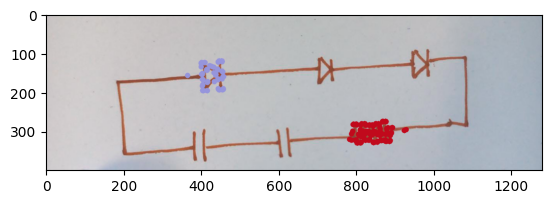

In [3539]:
plt.imshow(img7)

In [3540]:
remove_comp = dline.copy()
rects = []
rects_contour = []
components_extracted = []
for l,_ in enumerate(counts):
    if l == 0: continue
    px = [int(i[0]) for i in keypoints[labels == unique_labels[l]]]
    py = [int(i[1]) for i in keypoints[labels == unique_labels[l]]]
    if abs(max(py)-min(py))*abs(max(px)-min(px)) > 700:
        components_extracted.append(dline[min(py)-15:max(py)+15, min(px)-15:max(px)+15])
        remove_comp[min(py)-15:max(py)+15, min(px)-15:max(px)+15] = 0    
        rects_contour.append((np.array([[min(px)-15, min(py)-15],[max(px)+15, min(py)-15],[max(px)+15, max(py)+15],[min(px)-15, max(py)+15]])))
        rects.append([min(px)-22,max(px)+22,min(py)-22,max(py)+22])

(140, 207, 92)
(0, 37, 204)
(200, 130, 212)
(138, 170, 235)
(62, 48, 161)
(22, 167, 56)


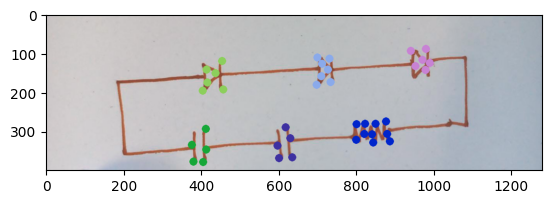

In [3541]:
anchor_points = cv2.goodFeaturesToTrack(image=dline,maxCorners=50,qualityLevel=0.50,minDistance=20)

# Convert the anchor points to a numpy array
anchor_points = np.float32(anchor_points.reshape((-1, 2)))

# Perform DBSCAN clustering on the anchor points
clustering = DBSCAN(eps=80, min_samples=5).fit(anchor_points)

# Get the labels for the clusters
labels = clustering.labels_

# Find the unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)

# Get the index of the label with the highest count
max_count_idx = np.argmax(counts)

# Get the points in the cluster with the highest count
max_count_points = anchor_points[labels == unique_labels[max_count_idx]]

# Draw circles around the points in the cluster with the highest count
img2 = img.copy()
for l in unique_labels:
    if l == -1: continue
    px = [int(i[0]) for i in anchor_points[labels == l]]
    py = [int(i[1]) for i in anchor_points[labels == l]]
    color = np.random.choice(range(256), size=3)
    color = (int (color [ 0 ]), int (color [ 1 ]), int (color [ 2 ]))
    print(color)
    for i in range(len(px)):
        cv2.circle(img2, (px[i], py[i]), 5, color=tuple(color), thickness=10)
    
plt.imshow(img2)
plt.show()

(10, 198, 206)
(7, 29, 16)
(91, 36, 19)
(16, 251, 136)
(12, 156, 159)
(114, 194, 5)


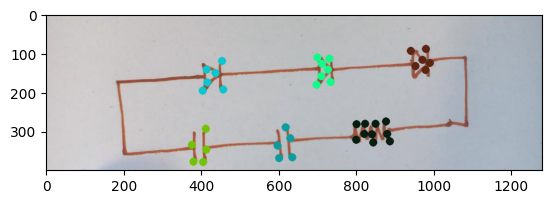

In [3542]:
anchor_points = cv2.goodFeaturesToTrack(image=dline,maxCorners=50,qualityLevel=0.50,minDistance=20)

# Convert the anchor points to a numpy array
anchor_points = np.float32(anchor_points.reshape((-1, 2)))

# Perform DBSCAN clustering on the anchor points
clustering = DBSCAN(eps=80, min_samples=5).fit(anchor_points)

# Get the labels for the clusters
labels = clustering.labels_

# Find the unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)

# Get the index of the label with the highest count
max_count_idx = np.argmax(counts)

# Get the points in the cluster with the highest count
max_count_points = anchor_points[labels == unique_labels[max_count_idx]]

# Draw circles around the points in the cluster with the highest count
img2 = img.copy()
for l in unique_labels:
    if l == -1: continue
    px = [int(i[0]) for i in anchor_points[labels == l]]
    py = [int(i[1]) for i in anchor_points[labels == l]]
    color = np.random.choice(range(256), size=3)
    color = (int (color [ 0 ]), int (color [ 1 ]), int (color [ 2 ]))
    print(color)
    for i in range(len(px)):
        cv2.circle(img2, (px[i], py[i]), 5, color=tuple(color), thickness=10)
    
plt.imshow(img2)
plt.show()

In [3543]:
sorted(counts)

[4, 5, 5, 6, 6, 7, 10]

In [3544]:
anchor_points[labels == unique_labels[max_count_idx]]

array([[880., 307.],
       [800., 322.],
       [844., 329.],
       [841., 308.],
       [821., 307.],
       [877., 275.],
       [887., 326.],
       [801., 282.],
       [850., 281.],
       [823., 281.]], dtype=float32)

In [3545]:
components_extracted = []

In [3546]:
remove_comp = dline.copy()
rects = []
rects_contour = []
for l,_ in enumerate(counts):
    if l == 0: continue
    px = [int(i[0]) for i in anchor_points[labels == unique_labels[l]]]
    py = [int(i[1]) for i in anchor_points[labels == unique_labels[l]]]
    if abs(max(py)-min(py))*abs(max(px)-min(px)) > 700:
        components_extracted.append(dline[min(py)-15:max(py)+15, min(px)-15:max(px)+15])
        remove_comp[min(py)-15:max(py)+15, min(px)-15:max(px)+15] = 0    
        rects_contour.append((np.array([[min(px)-15, min(py)-15],[max(px)+15, min(py)-15],[max(px)+15, max(py)+15],[min(px)-15, max(py)+15]])))
        rects.append([min(px)-22,max(px)+22,min(py)-22,max(py)+22])

In [3547]:
rects

[[382, 479, 98, 218],
 [778, 909, 253, 351],
 [919, 1012, 67, 165],
 [676, 756, 89, 203],
 [575, 657, 268, 391],
 [354, 435, 272, 401]]

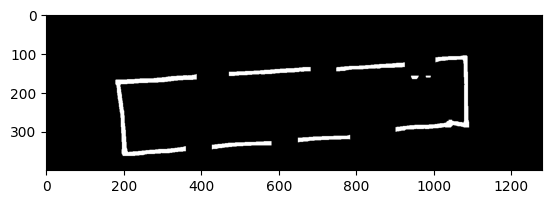

In [3548]:
plt.imshow(remove_comp, cmap='gray')

In [3549]:
# cnts = cv2.findContours(intersect1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     # Find centroid and draw center point
#     M = cv2.moments(c)
#     cx = int(M['m10']/M['m00'])
#     cy = int(M['m01']/M['m00'])
#     cv2.circle(img, (cx, cy), 5, (255,255,255), 10)

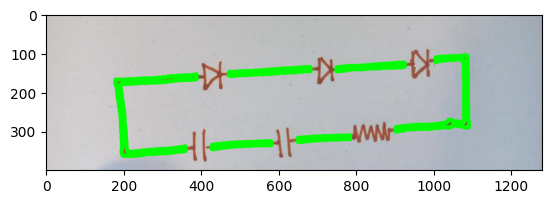

In [3550]:
# draw contours on removed component pic

contour = img.copy()
cnts = cv2.findContours(remove_comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_cnts = [c for c in cnts[0] if cv2.contourArea(c) > 600]
cv2.drawContours(contour, filtered_cnts, -1, (0,255,0), 10)
plt.imshow(contour, cmap='gray')

/Users/rushirajgadhvi/Library/Python/3.11/lib/python/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


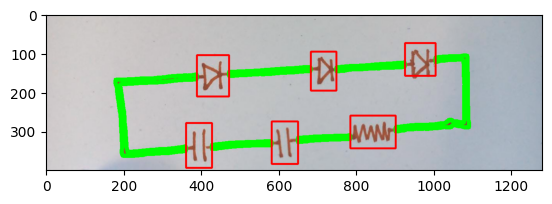

In [3551]:
cv2.drawContours(contour, tuple(rects_contour), -1, (255,0,0), 3)
plt.imshow(contour, cmap='gray')

In [3552]:
wiring_dict = {}
last_key = 0
for c in filtered_cnts:
    for rect in rects:
        for p in c:
            # rect[0] is xmin, rect[1] is xmax, rect[2] is ymin, rect[3] is ymax
            # p[0][0] is x, p[0][1] is y
            if p[0][0] >= rect[0] and p[0][0] <= rect[1] and p[0][1] >= rect[2] and p[0][1] <= rect[3]:
                if last_key not in wiring_dict.keys():
                    wiring_dict[last_key] = [rect]
                else:
                    wiring_dict[last_key].append(rect)
                break
    last_key += 1
                

# chnaged

In [3553]:
wiring_dict

{0: [[575, 657, 268, 391], [354, 435, 272, 401]],
 1: [[778, 909, 253, 351], [575, 657, 268, 391]],
 2: [[382, 479, 98, 218], [354, 435, 272, 401]],
 3: [[382, 479, 98, 218], [676, 756, 89, 203]],
 4: [[919, 1012, 67, 165], [676, 756, 89, 203]],
 5: [[778, 909, 253, 351], [919, 1012, 67, 165]]}

In [3554]:
key = 0
dict_len = len(wiring_dict)
del_wire = []

In [3555]:
while key < dict_len:
    if len(wiring_dict[key]) == 1:
        del_wire.append(key)
        del wiring_dict[key]
    key += 1

In [3556]:
wiring_dict

{0: [[575, 657, 268, 391], [354, 435, 272, 401]],
 1: [[778, 909, 253, 351], [575, 657, 268, 391]],
 2: [[382, 479, 98, 218], [354, 435, 272, 401]],
 3: [[382, 479, 98, 218], [676, 756, 89, 203]],
 4: [[919, 1012, 67, 165], [676, 756, 89, 203]],
 5: [[778, 909, 253, 351], [919, 1012, 67, 165]]}

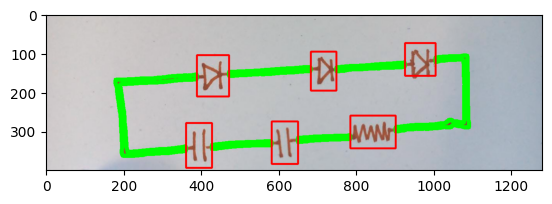

In [3557]:
img4 = img.copy()

for i in del_wire:
    del filtered_cnts[i]

cv2.drawContours(img4, filtered_cnts, -1, (0,255,0), 10)
cv2.drawContours(img4, tuple(rects_contour), -1, (255,0,0), 3)
plt.imshow(img4, cmap='gray')

In [3558]:
comp = components_extracted[0]
comp = cv2.morphologyEx(comp,cv2.MORPH_DILATE, np.ones((3,3), np.uint8), iterations=2)

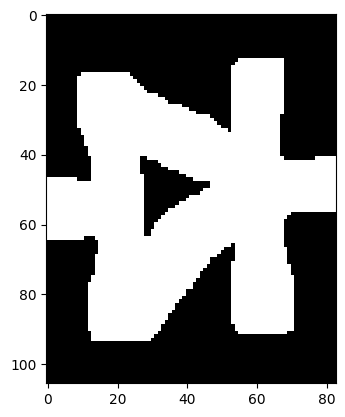

In [3559]:
plt.imshow(comp, cmap='gray')
